In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923, outputs
from pudl import clean_eia923, clean_ferc1, clean_pudl, mcoe
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.options.mode.chained_assignment = None
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56
pd.options.display.max_rows = 100

In [2]:
pudl_engine  = pudl.connect_db()

# Pulling the required tables

In [3]:
g9_summed = mcoe.generation_pull_eia923(pudl_engine)
g8, g8_es = mcoe.generators_pull_eia860(pudl_engine)
frc9_summed, frc9_summed_plant = mcoe.fuel_reciepts_costs_pull_eia923(pudl_engine)
bga8 = mcoe.boiler_generator_pull_eia860(pudl_engine)
bf9_summed, bf9_plant_summed = mcoe.boiler_fuel_pull_eia923(pudl_engine)

## Generating Capacity Factor

In [4]:
capacity_factor = analysis.capacity_factor(g9_summed,g8, id_col='plant_id_eia')

## Generating Heat Rate

In [7]:
heat_rate = mcoe.heat_rate(g8_es, bga8, g9_summed, bf9_summed,
              bf9_plant_summed, pudl_engine,
              plant_id='plant_id_eia', min_heat_rate=5.5)

## Generating Fuel Cost

In [13]:
fuel_cost = mcoe.fuel_cost(g8_es, g9_summed, frc9_summed, frc9_summed_plant, heat_rate)

### Merge fields together

In [108]:
# Merge relevant fuel cost fields with heat rate
mcoe_by_generator = fuel_cost[['plant_id_eia',
                               'plant_id_pudl',
                               'report_year',
                               'generator_id',
                               'energy_source',
                               'energy_source_cons',
                               'mmbtu_es',
                               'mmbtu_plant',
                               'fuel_cost_es',
                               'fuel_cost_plant',
                               'fuel_cost_per_mmbtu_es',
                               'fuel_cost_per_mmbtu_plant',
                               'fuel_cost_per_mwh']].merge(heat_rate,
                                                           on=['plant_id_eia',
                                                               'plant_id_pudl',
                                                               'report_year',
                                                               'generator_id'])

# Merge in capacity facotr
mcoe_by_generator = mcoe_by_generator.drop('net_generation_mwh', 
                                           axis=1).merge(capacity_factor,
                                                         on=['plant_id_eia',
                                                             'plant_id_pudl',
                                                             'report_year',
                                                             'generator_id'])

# Merge in plant level fuel consumption from bf9_plant_summed, rename field
mcoe_by_generator = mcoe_by_generator.merge(bf9_plant_summed,
                                            on=['plant_id_eia',
                                                'plant_id_pudl',
                                                'report_year'])
mcoe_by_generator.rename(columns={'fuel_consumed_mmbtu':'fuel_consumed_mmbtu_plant'},
                         inplace=True)

### Filter to include only plants >= 10 MW

In [109]:
# Now, let's grab only those plants larger than 10MW
mcoe_by_generator = mcoe_by_generator[mcoe_by_generator['nameplate_capacity_mw']>=10]

### Prep for Excel Output

In [111]:
# rearrange columns
mcoe_by_generator = mcoe_by_generator[[
    'plant_id_pudl',
    'plant_id_eia',
    'plant_name',
    'operator_name', 
    'state', 
    'report_year', 
    'generator_id', 
    'energy_source', 
    'energy_source_cons', 
    'mmbtu_es', 
    'mmbtu_plant',
    'fuel_cost_es', 
    'fuel_cost_plant',
    'fuel_cost_per_mmbtu_es',
    'fuel_cost_per_mmbtu_plant',
    'fuel_cost_per_mwh',
    'fuel_consumed_mmbtu_plant',
    'fuel_consumed_mmbtu_generator',
    'heat_rate_mmbtu_mwh',
    'complete_assn',
    'plant_assn', 
    'heatrate_calc',
    'net_generation_mwh', 
    'nameplate_capacity_mw', 
    'summer_capacity_mw',
    'winter_capacity_mw',
    'capacity_factor']]

In [134]:
mcoe_annotations = pd.read_csv('mcoe_field_annotations_detailed_eia.csv')
mcoe_notes = pd.read_csv('mcoe_notes.csv')

In [122]:
# to export all the data
xlsx_writer = pd.ExcelWriter('MCOE_by_generator_eia_2014-2016.xlsx')
mcoe_by_generator.to_excel(xlsx_writer, sheet_name='MCOE by Generator', index=False, na_rep='NA')
mcoe_annotations.to_excel(xlsx_writer, sheet_name='MCOE Annotations', index=False)
mcoe_notes.to_excel(xlsx_writer, sheet_name='MCOE Notes', index=False)

xlsx_writer.save()

## Let's take a peak

In [52]:
coal = mcoe_by_generator[mcoe_by_generator['energy_source_cons'] == 'coal']

In [54]:
gas = mcoe_by_generator[mcoe_by_generator['energy_source_cons'] == 'gas']

In [56]:
other = mcoe_by_generator[(mcoe_by_generator['energy_source_cons'] != 'gas') & (mcoe_by_generator['energy_source_cons'] != 'coal')]

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


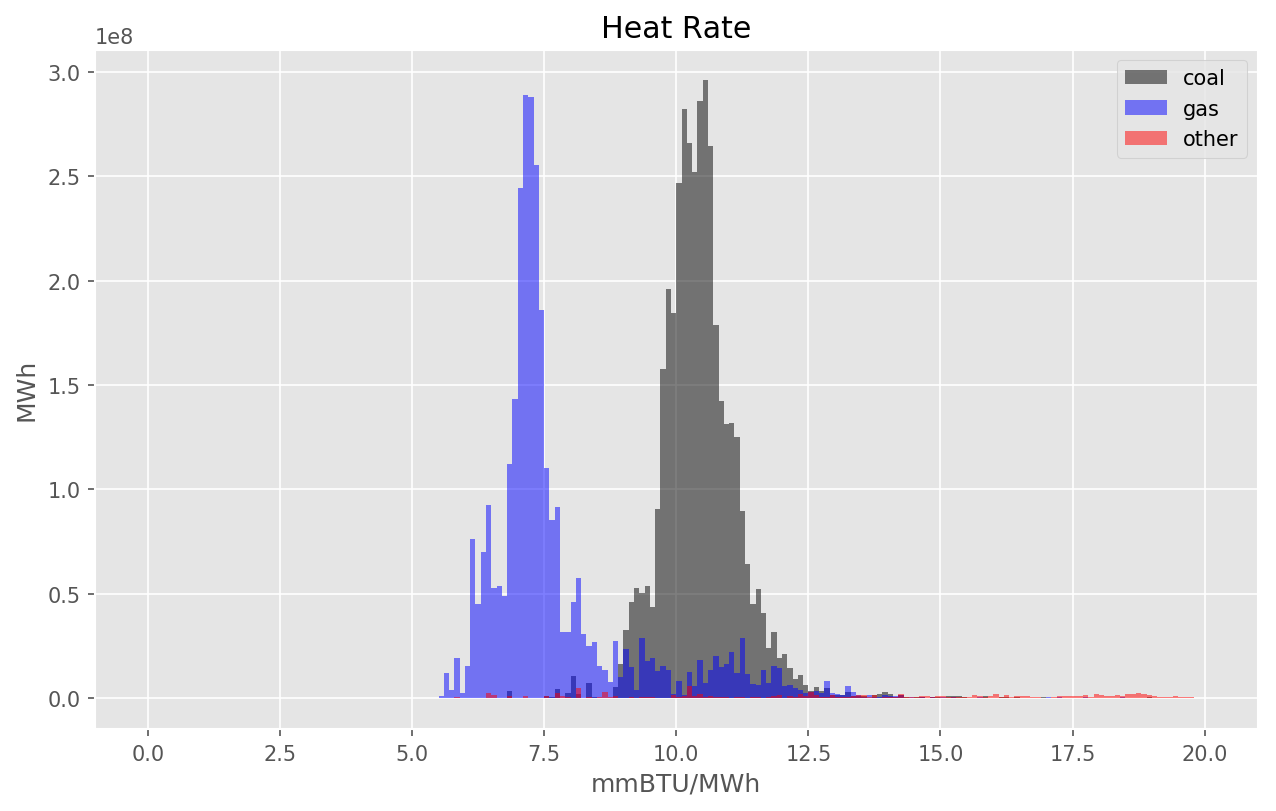

In [124]:
#quick look at spread in fuel_cost_per_mwh for these plants
plt.hist(coal.heat_rate_mmbtu_mwh, range=(0,20), weights=coal.net_generation_mwh, bins=200, alpha=0.5, color='black', label='coal')
plt.hist(gas.heat_rate_mmbtu_mwh, range=(0,20), weights=gas.net_generation_mwh, bins=200, alpha=0.5, color='blue', label='gas')
plt.hist(other.heat_rate_mmbtu_mwh, range=(0,20), weights=other.net_generation_mwh, bins=200, alpha=0.5, color='red',label='other')
plt.legend()
plt.xlabel("mmBTU/MWh")
plt.ylabel("MWh")
plt.title("Heat Rate")

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


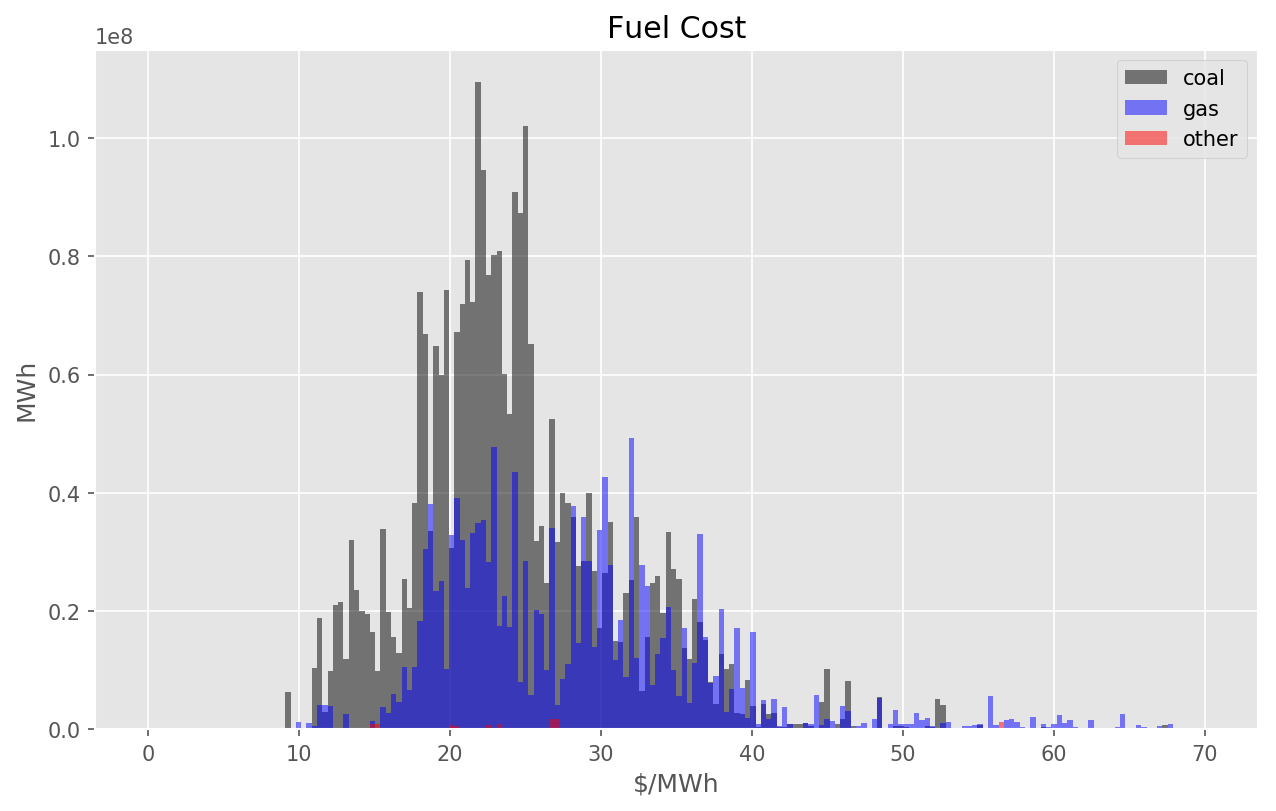

In [123]:
#quick look at spread in fuel_cost_per_mwh for these plants
plt.hist(coal.fuel_cost_per_mwh, range=(0,70), weights=coal.net_generation_mwh, bins=200, alpha=0.5, color='black', label='coal')
plt.hist(gas.fuel_cost_per_mwh, range=(0,70), weights=gas.net_generation_mwh, bins=200, alpha=0.5, color='blue', label='gas')
plt.hist(other.fuel_cost_per_mwh, range=(0,70), weights=other.net_generation_mwh, bins=200, alpha=0.5, color='red',label='other')
plt.legend()
plt.xlabel("$/MWh")
plt.ylabel("MWh")
plt.title("Fuel Cost")

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


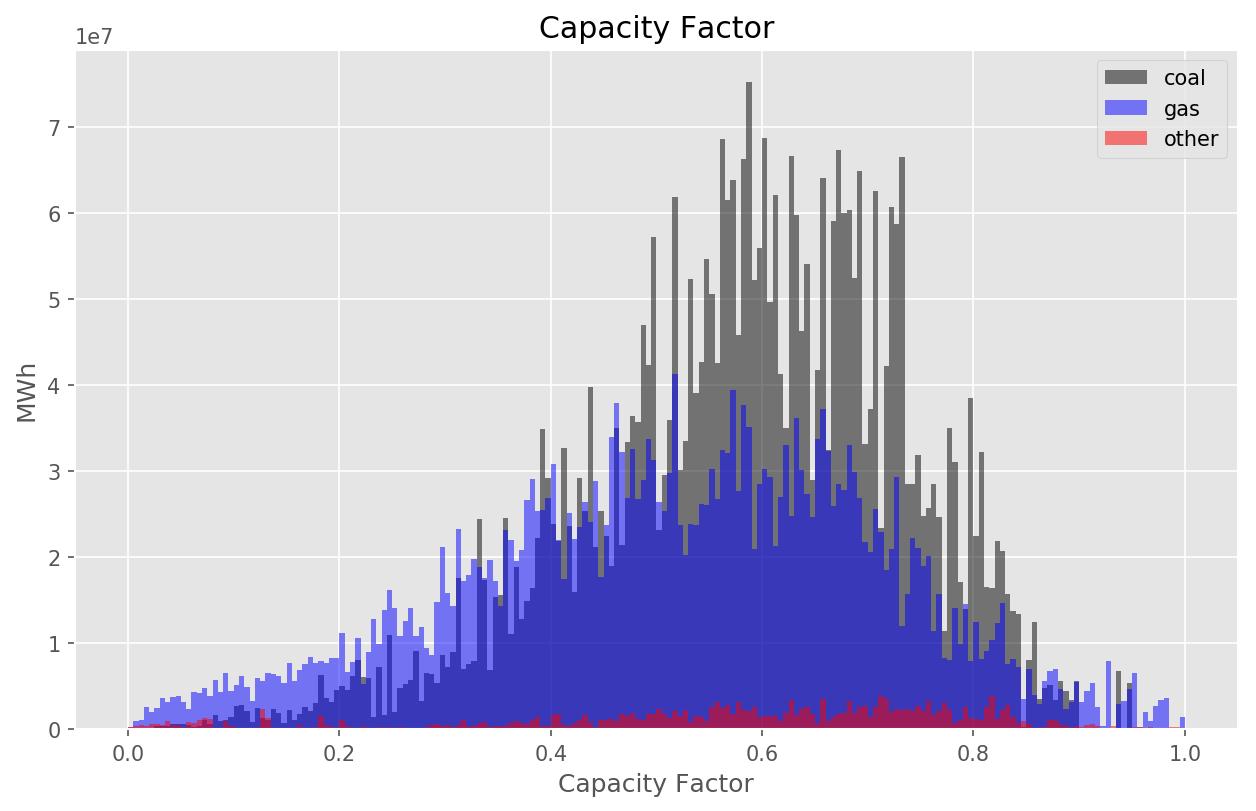

In [77]:
#quick look at spread in fuel_cost_per_mwh for these plants
plt.hist(coal.capacity_factor, range=(0,1), weights=coal.net_generation_mwh, bins=200, alpha=0.5, color='black', label='coal')
plt.hist(gas.capacity_factor, range=(0,1), weights=gas.net_generation_mwh, bins=200, alpha=0.5, color='blue', label='gas')
plt.hist(other.capacity_factor, range=(0,1), weights=other.net_generation_mwh, bins=200, alpha=0.5, color='red',label='other')
plt.legend()
plt.xlabel("Capacity Factor")
plt.ylabel("MWh")
plt.title("Capacity Factor")

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


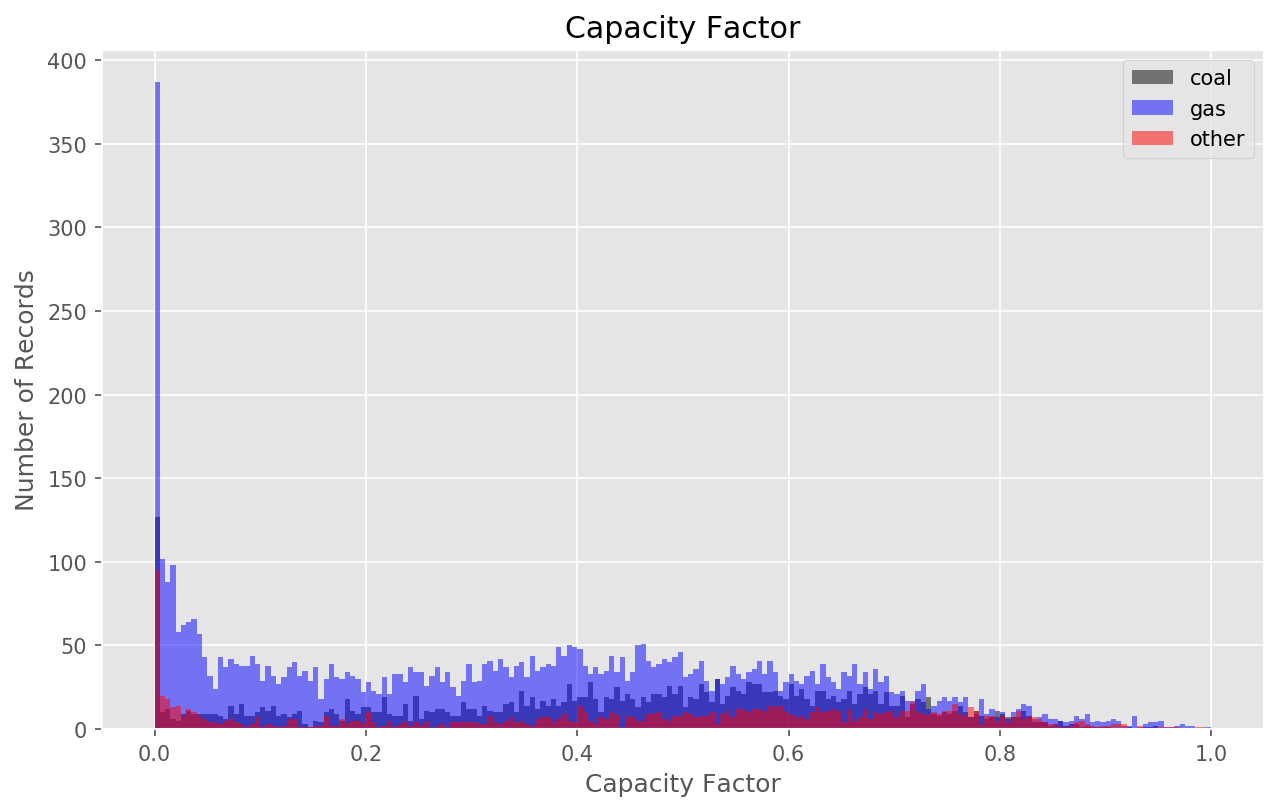

In [74]:
#quick look at spread in fuel_cost_per_mwh for these plants
plt.hist(coal.capacity_factor, range=(0,1),  bins=200, alpha=0.5, color='black', label='coal')
plt.hist(gas.capacity_factor, range=(0,1), bins=200, alpha=0.5, color='blue', label='gas')
plt.hist(other.capacity_factor, range=(0,1), bins=200, alpha=0.5, color='red',label='other')
plt.legend()
plt.xlabel("Capacity Factor")
plt.ylabel("Number of Records")
plt.title("Capacity Factor")

## A few plots

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


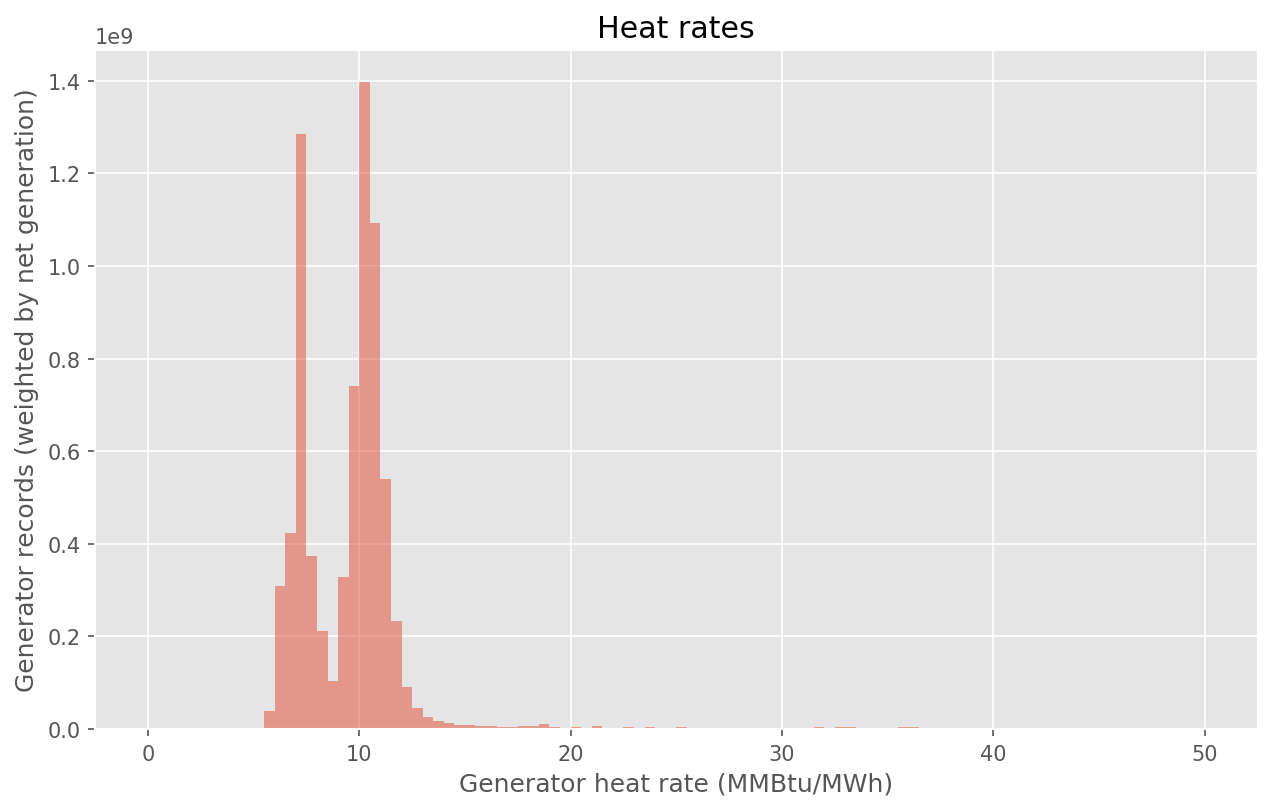

In [126]:
# Take a look at heat rates from EIA
plt.hist(heat_rate.heat_rate_mmbtu_mwh, range=[0,50],bins=100,weights=heat_rate.net_generation_mwh, alpha=0.5)
#heat_rate['heat_rate_mmbtu_mwh'].plot(kind='hist', bins=100, range=[-20,70])
plt.xlabel('Generator heat rate (MMBtu/MWh)')
plt.ylabel("Generator records (weighted by net generation)")
plt.title("Heat rates")
plt.show()

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


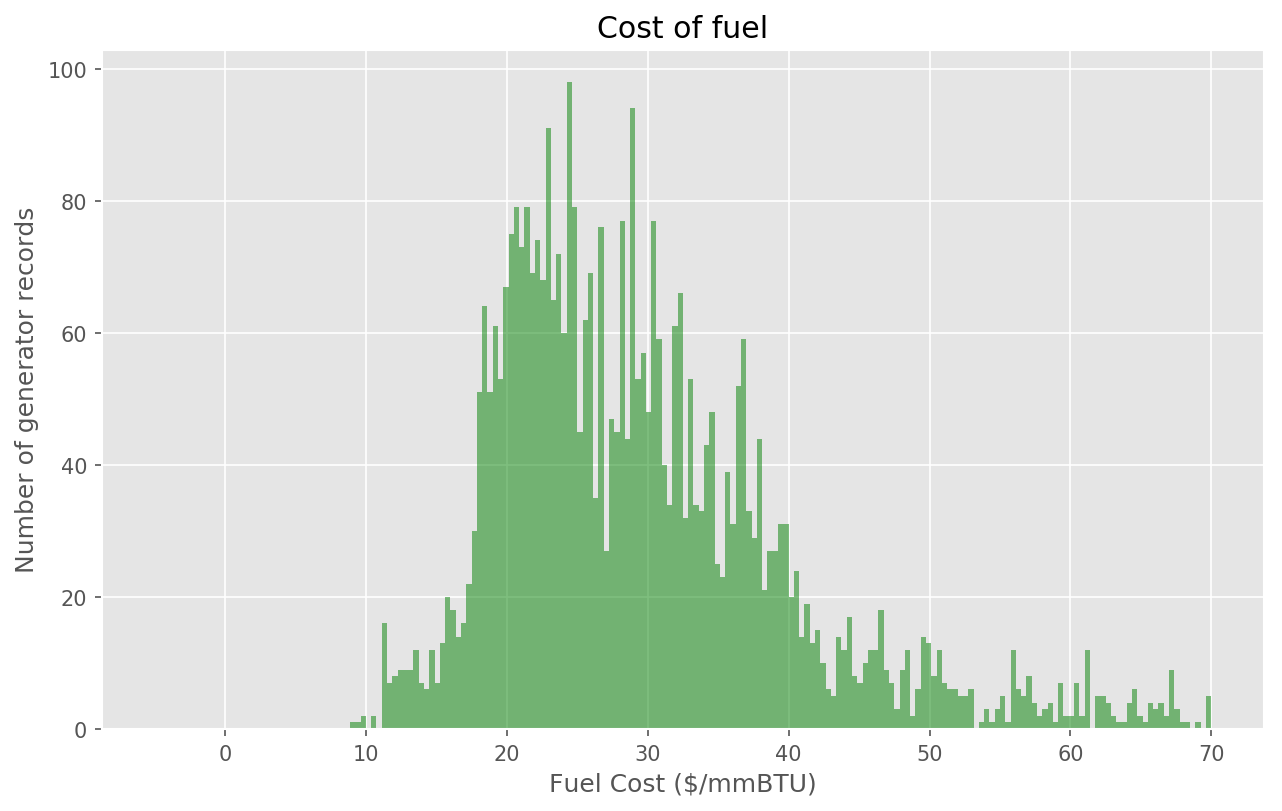

In [130]:
#quick look at spread in fuel_cost_per_mmbtu
plt.hist(mcoe_by_generator.fuel_cost_per_mwh, range=(-5,70), bins=200, alpha=0.5, color='green')
plt.xlabel("Fuel Cost ($/mmBTU)")
plt.ylabel("Number of generator records")
plt.title("Cost of fuel")
plt.legend()

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


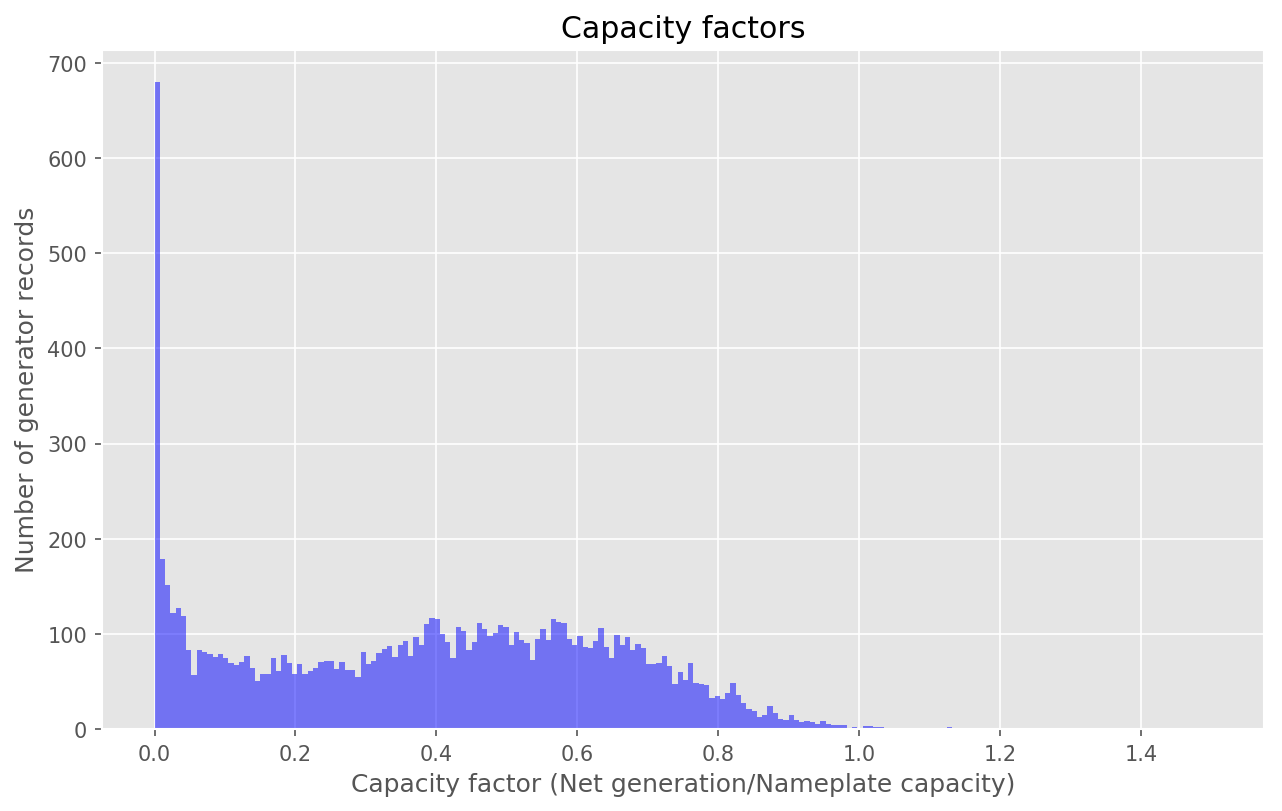

In [131]:
#quick look at capacity factors
plt.hist(mcoe_by_generator.capacity_factor, range=(0,1.5), bins=200, alpha=0.5, color='blue')
plt.xlabel("Capacity factor (Net generation/Nameplate capacity)")
plt.ylabel("Number of generator records")
plt.title("Capacity factors")
plt.legend()